In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History
import netron

In [2]:
def padd_audio(audio, max_duration=5, sample_rate=16000):
    """This function take an audio and padd that audio with zeros"""
    
    max_length = max_duration * sample_rate
    padding_needed = max_length - len(audio)
    pad_left = padding_needed // 2
    pad_right = padding_needed - pad_left
    
    return np.pad(audio, (pad_left, pad_right), 'constant')

In [3]:
def mix_audio(original_audio_path, noise_audio_path, sample_rate=16000):
    """This function take an original audio path and noise audio path and mix it together"""
    
    # Load the original audio
    original_audio, sr = librosa.load(original_audio_path, sr=sample_rate)
    
    #Padd original audio
    original_audio = padd_audio(original_audio, sample_rate=sample_rate)
    
    # Load the noise audio
    noise_audio, sr_noise = librosa.load(noise_audio_path, sr=sample_rate)
    
    # Repeat the noise audio
    noise_audio = np.tile(noise_audio, int(np.ceil(len(original_audio) / len(noise_audio))))

    # Trim the repeated noise audio to match the length of the original audio
    noise_audio = noise_audio[:len(original_audio)]
    
    return original_audio + noise_audio/2

In [4]:
def get_clean_audio(original_audio_path, sample_rate=16000):
    """This function take an original audio path and return padded audio"""
    
    # Load the original audio
    original_audio, sr = librosa.load(original_audio_path, sr=sample_rate)
    
    #Padd original audio
    return padd_audio(original_audio, sample_rate=sample_rate)

In [5]:
# Randmly chosen noise for each audio
def combine_audio_with_noise(original_audio_dir, noise_audio_dir):
    combination_dict = {}
    noise_audios = os.listdir(noise_audio_dir)
    original_audios = os.listdir(original_audio_dir)
    
    for original_audio in original_audios:
        noise_audio = np.random.choice(noise_audios)
        combination_dict[os.path.join(original_audio_dir, original_audio)] = os.path.join(noise_audio_dir, noise_audio)
        
    return combination_dict

In [6]:
def audio_to_stft(audio, n_fft=1199, hop_length_fft=304):
    # STFT transformation
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)

    # Extract magnitude and phase
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    # Convert magnitude to dB
    stftaudio_magnitude_db = librosa.amplitude_to_db(stftaudio_magnitude, ref=np.max)
    
    return stftaudio_magnitude_db, stftaudio_phase

In [7]:
def stft_to_audio(stftaudio_magnitude_db, stftaudio_phase, hop_length_fft=304):
# Convert dB back to amplitude
    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # Reconstruct the STFT complex matrix
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase

    # Inverse STFT to get back the audio signal
    audio_reconstruct = librosa.istft(audio_reverse_stft, hop_length=hop_length_fft)

    return audio_reconstruct / np.max(np.abs(audio_reconstruct))

In [8]:
# Example of normalization function using global min and max values
def normalize(stft, global_min, global_max):
    return (stft - global_min) / (global_max - global_min)

# Example of denormalization function using global min and max values
def denormalize(normalized_stft, global_min, global_max):
    return normalized_stft * (global_max - global_min) + global_min

In [9]:
def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_'+string])
        plt.title(string+' through epochs')
        plt.show()

# Preprocessing the data

In [10]:
sr = 16000  # Sampling rate   

In [11]:
audio_noise_pairs = combine_audio_with_noise(os.path.join(os.getcwd(), 'Dataset'), os.path.join(os.getcwd(), 'Noise'))

#Getting all the noisy and clean audio matrices
noisy_audios = np.zeros(len(audio_noise_pairs), dtype=object)
clean_audios = np.zeros(len(audio_noise_pairs), dtype=object)

for index, (audio_dir, noise_dir) in enumerate(audio_noise_pairs.items()):
    noisy_audios[index] = mix_audio(audio_dir, noise_dir, sample_rate=16000)
    clean_audios[index] = get_clean_audio(audio_dir, sample_rate=16000)

In [12]:
#Getting STFT data for learning process
noisy_audios_stft = [audio_to_stft(audio)[0] for audio in noisy_audios]
noisy_audios_stft_phase = [audio_to_stft(audio)[1] for audio in noisy_audios]
clean_audios_stft = [audio_to_stft(audio)[0] for audio in clean_audios]

In [13]:
#Splitting the data for training 80%, validation 10% and test set 10%
split_ratio1 = 0.8
split_ratio2 = 0.9
split_index1 = int(len(noisy_audios_stft) * split_ratio1)
split_index2 = int(len(noisy_audios_stft) * split_ratio2)

X_train = noisy_audios_stft[:split_index1]
X_val = noisy_audios_stft[split_index1:split_index2]
X_test = noisy_audios_stft[split_index2:]

y_train = clean_audios_stft[:split_index1]
y_val = clean_audios_stft[split_index1:split_index2]
y_test = clean_audios_stft[split_index2:]

phase_train = noisy_audios_stft_phase[:split_index1]
phase_val = noisy_audios_stft_phase[split_index1:split_index2]
phase_test = noisy_audios_stft_phase[split_index2:]

In [14]:
# Find the global min and max values from both the noisy and clean STFT data
global_min = min(np.min(X_train), np.min(y_train))
global_max = max(np.max(X_train), np.max(y_train))

In [15]:
#Normalize data based on the data from training set
X_train_normalized = normalize(X_train, global_min, global_max)
X_val_normalized = normalize(X_val, global_min, global_max)
X_test_normalized = normalize(X_test, global_min, global_max)

y_train_normalized = normalize(y_train, global_min, global_max)
y_val_normalized = normalize(y_val, global_min, global_max)
y_test_normalized = normalize(y_test, global_min, global_max)

In [16]:
#Transform data to tensors: sample x dimensions(n x n) x channel(1)
X_train_normalized = X_train_normalized[..., np.newaxis]
X_val_normalized = X_val_normalized[..., np.newaxis]
X_test_normalized = X_test_normalized[..., np.newaxis]

y_train_normalized = y_train_normalized[..., np.newaxis]
y_val_normalized = y_val_normalized[..., np.newaxis]
y_test_normalized = y_test_normalized[..., np.newaxis]

# Model

In [17]:
def generator(X, y, batch_size=16, epochs=100):
    assert len(X) == len(y), "The length of X and y must be the same"
    
    # Iterate through each epoch
    for epoch in range(epochs):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_X = X_shuffled[start:end]
            batch_y = y_shuffled[start:end]
            
            yield batch_X, batch_y

In [18]:
# Encoder
def encoder(inputs):
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)
    
    encoded = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
    return encoded

# Decoder
def decoder(encoded):
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_regularizer=l2(0.0005))(x)  # Single channel output
    return decoded

In [19]:
#Batch size
batch_size = 16

# Input shape
input_shape = (600, 264, 1)
inputs = Input(shape=input_shape)

# Build the autoencoder
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = Model(inputs, decoded)

# Optimizer adapts learning rate based on batch size, using Adam optimizer
optimizer = Adam(learning_rate=0.01*(batch_size/256), beta_1=0.9, beta_2=0.999)

autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
autoencoder.summary()

# Initialize model checkpointing to save the model with the lowest loss.
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Set up early stopping to halt training if loss doesn't improve after 20 epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min', verbose=1)

# Configure learning rate reduction if loss doesn't improve after 3 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0000001)

# Fit the model
history = autoencoder.fit(generator(X_train_normalized, y_train_normalized),
                          steps_per_epoch=len(X_train_normalized) // batch_size,
                          epochs=100,
                          validation_data=(X_val_normalized, y_val_normalized),
                          callbacks=[model_checkpoint, early_stopping, reduce_lr])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 264, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 600, 264, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 600, 264, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 300, 132, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 300, 132, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 132, 128)     73856 

34/34 [==============================] - 687s 20s/step - loss: 0.0309 - val_loss: 0.0555 - lr: 3.1250e-04
Epoch 16/100
34/34 [==============================] - ETA: 0s - loss: 0.0278 
Epoch 16: val_loss did not improve from 0.05228
34/34 [==============================] - 629s 18s/step - loss: 0.0278 - val_loss: 0.0532 - lr: 3.1250e-04
Epoch 17/100
34/34 [==============================] - ETA: 0s - loss: 0.0260 
Epoch 17: val_loss improved from 0.05228 to 0.05015, saving model to best_model.h5
34/34 [==============================] - 619s 18s/step - loss: 0.0260 - val_loss: 0.0501 - lr: 3.1250e-04
Epoch 18/100
34/34 [==============================] - ETA: 0s - loss: 0.0251 
Epoch 18: val_loss improved from 0.05015 to 0.04864, saving model to best_model.h5
34/34 [==============================] - 641s 19s/step - loss: 0.0251 - val_loss: 0.0486 - lr: 3.1250e-04
Epoch 19/100
34/34 [==============================] - ETA: 0s - loss: 0.0239 
Epoch 19: val_loss improved from 0.04864 to 0.0458

Epoch 47/100
34/34 [==============================] - ETA: 0s - loss: 0.0159 
Epoch 47: val_loss improved from 0.01732 to 0.01688, saving model to best_model.h5
34/34 [==============================] - 639s 19s/step - loss: 0.0159 - val_loss: 0.0169 - lr: 3.9062e-05
Epoch 48/100
34/34 [==============================] - ETA: 0s - loss: 0.0158 
Epoch 48: val_loss improved from 0.01688 to 0.01558, saving model to best_model.h5
34/34 [==============================] - 655s 19s/step - loss: 0.0158 - val_loss: 0.0156 - lr: 3.9062e-05
Epoch 49/100
34/34 [==============================] - ETA: 0s - loss: 0.0162 
Epoch 49: val_loss improved from 0.01558 to 0.01543, saving model to best_model.h5
34/34 [==============================] - 645s 19s/step - loss: 0.0162 - val_loss: 0.0154 - lr: 3.9062e-05
Epoch 50/100
34/34 [==============================] - ETA: 0s - loss: 0.0158 
Epoch 50: val_loss improved from 0.01543 to 0.01538, saving model to best_model.h5
34/34 [==============================]

34/34 [==============================] - 635s 19s/step - loss: 0.0146 - val_loss: 0.0138 - lr: 2.4414e-06
Epoch 79/100
34/34 [==============================] - ETA: 0s - loss: 0.0147 
Epoch 79: val_loss did not improve from 0.01376
34/34 [==============================] - 638s 19s/step - loss: 0.0147 - val_loss: 0.0138 - lr: 1.2207e-06
Epoch 80/100
34/34 [==============================] - ETA: 0s - loss: 0.0146 
Epoch 80: val_loss did not improve from 0.01376
34/34 [==============================] - 636s 19s/step - loss: 0.0146 - val_loss: 0.0138 - lr: 1.2207e-06
Epoch 81/100
34/34 [==============================] - ETA: 0s - loss: 0.0149 
Epoch 81: val_loss did not improve from 0.01376

Epoch 81: ReduceLROnPlateau reducing learning rate to 6.103515488575795e-07.
34/34 [==============================] - 637s 19s/step - loss: 0.0149 - val_loss: 0.0138 - lr: 1.2207e-06
Epoch 82/100
34/34 [==============================] - ETA: 0s - loss: 0.0145 
Epoch 82: val_loss improved from 0.01376 t

# Results

In [20]:
#Network visualization
netron.start('best_model.h5')

Serving 'best_model.h5' at http://localhost:8080


('localhost', 8080)

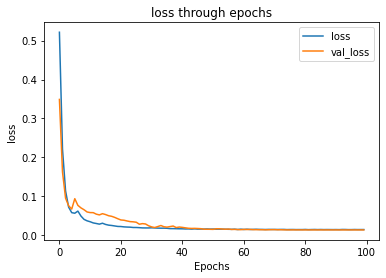

In [21]:
plot_graphs(history, 'loss')

In [22]:
#Train loss
train_loss = autoencoder.evaluate(X_train_normalized, y_train_normalized, verbose=1)

#Validation loss
val_loss = autoencoder.evaluate(X_val_normalized, y_val_normalized, verbose=1)

#Test loss
test_loss = autoencoder.evaluate(X_test_normalized, y_test_normalized, verbose=1)

results = pd.DataFrame([[train_loss, val_loss, test_loss]],
            columns = ['train', 'validation', 'test'])
results

3/3 [==============================] - 24s 7s/step - loss: 0.0141


,train,validation,test
0,0.013817,0.013727,0.014147


# Predictions

In [23]:
def get_audio_predictions(output_prediction, phase, global_min=global_min, global_max=global_max):
    prediction = denormalize(output_prediction.squeeze(), global_min, global_max)
    audio_prediction = stft_to_audio(prediction, phase, hop_length_fft=304)
    return audio_prediction

In [24]:
autoencoder=load_model('best_model.h5')

In [25]:
predictions = autoencoder.predict(X_test_normalized)

3/3 [==============================] - 19s 4s/step


In [44]:
audio_pred = get_audio_predictions(predictions, phase_test)

In [51]:
#Save all the predictions for test data
for i, element in enumerate(audio_pred):
    sf.write(f'audio_pred{i}.wav', audio_pred[i], samplerate=sr)
    sf.write(f'audio_noisy{i}.wav', stft_to_audio(X_test[i], phase_test[i], hop_length_fft=304), samplerate=sr)

# Visual results

In [75]:
def plot_spectogram(stft_audio): # Plot the spectrogram
    plt.figure(figsize=(15, 5)) 
    librosa.display.specshow(stft_audio, sr=sr, y_axis='hz')
    plt.colorbar()
    plt.show()

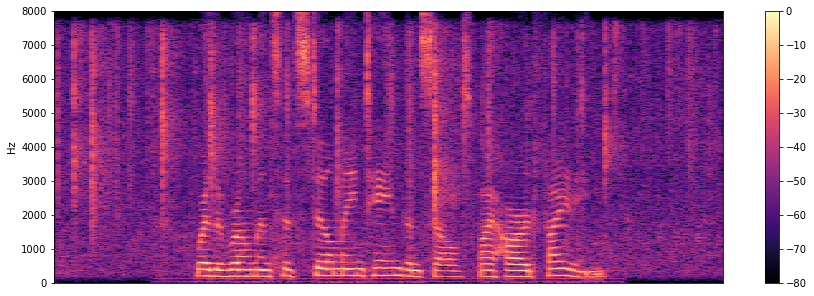

In [78]:
# Plot the audio with rain noise
plot_spectogram(X_test[4])

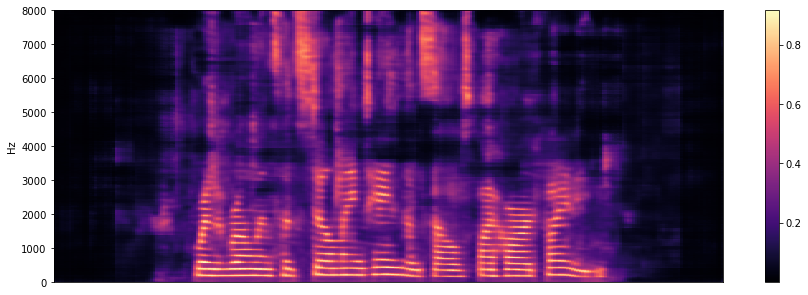

In [77]:
# Plot the same audio after denoised
plot_spectogram(predictions[4].squeeze())

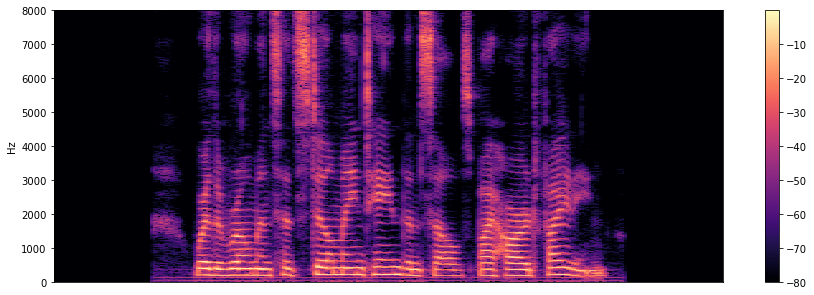

In [80]:
# Plot the original audio without any rain
plot_spectogram(y_test[4])